In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Motivation

Effective decision-making is key to streamlining the loan underwriting process for banks. According to [[1]](), providing the right information to a model can lead to high performance in determining whether to approve a loan. However, there are certain variables, such as income, that may not be immediately accessible and require additional time to verify. As banks seek to optimize the underwriting process, it is important for them to anticipate this uncertainty and weigh the potential risks and profits.

In this series, we will explore different techniques for managing uncertainty in machine learning models when making predictions. In this first chapter, I will demonstrate the impact of the income feature when building the loan approval model. 

In [2]:
df = pd.read_csv("../data/loan-train.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


(614, 13)

In [3]:
df["Loan_Status"] = (df["Loan_Status"] == "Y").astype(int)

## Feature engineering

**Total income**

Applicant income and Coapplicant income can determine the loan amount that customer can take.

In [4]:
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]

**Income Bin**

In [5]:
total_income_bin_names = ["<= 3500", "(3500, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"]

df["TotalIncomeBin"] = pd.cut(
    df["TotalIncome"], 
    bins=[-np.inf, 3500, 5000, 9000, 17000, np.inf],
    labels=total_income_bin_names
)  # .astype(str)

# _ = sns.histplot(df["TotalIncomeBin"])

df["TotalIncomeBin"] = df["TotalIncomeBin"].astype(str)

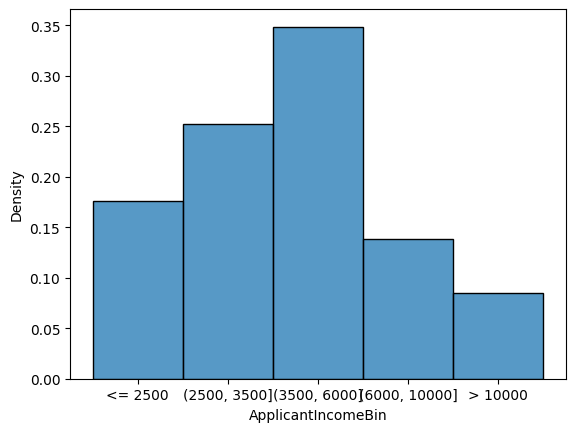

In [6]:
applicant_income_bin_names = ["<= 2500", "(2500, 3500]", "(3500, 6000]", "(6000, 10000]", "> 10000"]

df["ApplicantIncomeBin"] = pd.cut(
    df["ApplicantIncome"], 
    bins=[-np.inf, 2500, 3500, 6000, 10000, np.inf],
    labels=applicant_income_bin_names
)  # .astype(str)

_ = sns.histplot(df["ApplicantIncomeBin"], stat="density")

df["ApplicantIncomeBin"] = df["ApplicantIncomeBin"].astype(str)

**Monthly payment** [[2]]()

If bank approve the loan, what is the minimum monthly payment?

$$
M = P\frac{r(1+r)^n}{(1+r)^n - 1}
$$

Where, 

$M$ is the monthly payment

$P$ is the mortgage amount

$r$ is the monthly interest rate

$n$ is the number of payment

</br>

In [7]:
from calculations import calculate_mortgage_payment_per_month

In [8]:
df["MonthlyPayment"] = list(map(
    lambda p: calculate_mortgage_payment_per_month(p * 1_000), df["LoanAmount"]
))

**Expected profit**

In [9]:
df["TotalPay"] = df["MonthlyPayment"] * 360
df["ExpectedProfit"] = df["TotalPay"] - (df["LoanAmount"] * 1_000)

In [10]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncomeBin,ApplicantIncomeBin,MonthlyPayment,TotalPay,ExpectedProfit
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,"(5000, 9000]","(3500, 6000]",NaN,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,"(5000, 9000]","(3500, 6000]",767.424672,276272.881990,148272.881990
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,<= 3500,"(2500, 3500]",395.703347,142453.204776,76453.204776
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,"(3500, 5000]","(2500, 3500]",719.460630,259005.826866,139005.826866
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,"(5000, 9000]","(3500, 6000]",845.366240,304331.846568,163331.846568


In [27]:
# df.to_csv("../data/00_enriched_data.csv", index=False)

## Baseline loan model

Let's build the baseline for loan approval model.

In [11]:
from modeling import encode_categorical_features, encode_categorical_features_v2, encode_all, apply_encoders, rollout_result, encode_numerical_features

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [12]:
df_copy = df.dropna().copy()

In [13]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See 

In [14]:
mean_scores

0.80625

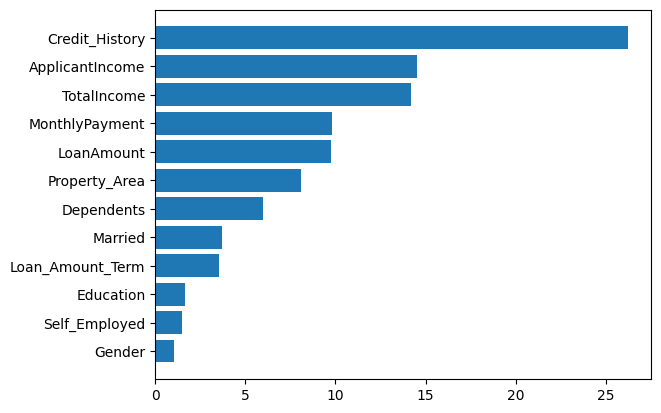

In [15]:
idx = np.argsort(best_model.feature_importances_)
_ = plt.barh(np.array(best_model.feature_names_)[idx], np.array(best_model.feature_importances_)[idx])

This shows the accuracy of the model is around 80%. However, we don't just want to know how accurate it is but we also want to know the opportunity loss when using this model.

In [16]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)

train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [17]:
model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
_ = model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

In [18]:
test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

In [19]:
test.reset_index(drop=True, inplace=True)

test["pred"] = model.predict(test_encoded.drop("Loan_Status", axis=1))

In [20]:
pd.DataFrame(
    confusion_matrix(
        test_encoded["Loan_Status"],
        test["pred"],
        labels=[1, 0]
    ),
    index=[1, 0],
    columns=[1, 0]
)

,1,0
1,58,2
0,16,20


The above table is a confusion matrix, where $i^{th}$ row represents the actual loan status and $j^{th}$ column represents the predicted outcome. 

In the banking context, we don't want False Positive (FP) to be high because this means we give the loan to borrowers who might not be able to payback, which can result in an opportunity loss for the bank.

**Opportunity loss = (cost of false positives * number of false positives) + (cost of false negatives * number of false negatives)**

Assuming the cost of false positive is equal to the loan amount and cost of false negative is zero.

In [21]:
FP = test[
    (test["Loan_Status"] == 0) &
    (test["pred"] == 1)
]

TP = test[
    (test["Loan_Status"] == 1) & 
    (test["pred"] == 1)
]

In [22]:
opportunity_loss = FP["LoanAmount"].sum() * 1_000
opportunity_loss

2554000.0

In [23]:
expected_profit = TP["ExpectedProfit"].sum()
expected_profit

8320657.119820111

Where, **Accept rate** is around 77%

Let's see if we drop all income-related features out.

In [24]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[],
    target="Loan_Status"
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See 

In [25]:
mean_scores

0.7770833333333333

In [26]:
# idx = np.argsort(best_model.feature_importances_)
# _ = plt.barh(np.array(best_model.feature_names_)[idx], np.array(best_model.feature_importances_)[idx])

Obviously, removing the income-related features affects the performance of the model. 

# References

1. [Loan Prediction w/ Various ML Models](https://www.kaggle.com/code/caesarmario/loan-prediction-w-various-ml-models/notebook)
2. [Mortgage Calculator](https://www.bankrate.com/mortgages/mortgage-calculator/)